<a href="https://colab.research.google.com/github/rawat126/DL-ML/blob/master/Denoising%20Autoencoders/Denoising_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising X-Ray Images Using Stacked Autoencoders

Autoencoders are Neural Networks which are commonly used for feature selection and extraction. However, when there are more nodes in the hidden layer than there are inputs, the Network is risking to learn the so-called “Identity Function”, also called “Null Function”, meaning that the output equals the input, marking the Autoencoder useless.

The idea behind denoising autoencoders is simple. In order to force the hidden layer to discover more robust features and prevent it from simply learning the identity, we train the autoencoder to reconstruct the input from a corrupted version of it.

#Importing Necessary Libraries

In [17]:
import keras 
import tensorflow as tf
from keras.layers import Conv2D,Flatten,UpSampling2D
from keras.layers import MaxPooling2D,Dense,Input
from keras.layers import Dropout,BatchNormalization,Conv2DTranspose
from keras.models import Sequential,Model
from keras import optimizers
import numpy as np
import pandas as pd
from google.colab import drive
import cv2
import pickle as pk
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
import imutils
from sklearn.preprocessing import MinMaxScaler
import os
from keras.models import load_model
import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


**NOISE INTRODUCTION**

we are using the **Gaussian Noise** with large ratio( =12 ) for our Noisy Data. The Gaussion noise Algorithum Discussed in [this Blog](https://uomustansiriyah.edu.iq/media/lectures/5/5_2017_03_26!05_29_23_PM.pdf) is being coded in mentioned function

In [55]:
def gaussian_noise(image, noise):    
    typ = image.dtype
    for i in range(noise):
        val = np.random.randint(0,10,[image.shape[0],image.shape[1],image.shape[2]])
        
        for cha in range(image.shape[2]):
            for row in range(image.shape[0]):
                for col in range(image.shape[1]):

                    if val[row,col,cha] == 0:
                        image[row,col,cha] = 0
                    
                    elif val[row,col,cha] == image[row,col,cha]:
                        image[row,col,cha] = 255
                    
    image = image.astype(typ)
    return image

In [53]:
# data Directory Path 
dir_path = '/content/drive/My Drive/Normal/'

# Refrence Image path used for Noise Effect Demonstration
ref_img_path = '/content/drive/My Drive/Normal/7.jpeg'

**NOISE  EFFECT  DEMONSTRATION**

*   Below Two Image will Show thw effect on Original Image ofter Introduction of Noise



Text(0.5, 1.0, 'Noisy Image')

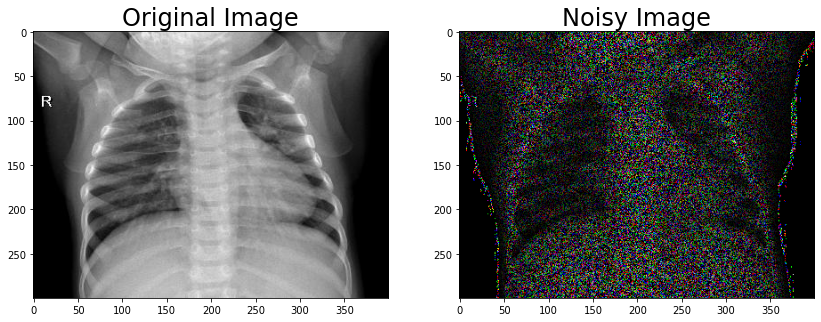

In [ ]:
f,ax = plt.subplots(1,2)
f.set_figwidth(14)
f.set_figheight(10)

# reading the refrence image...
ref_img = cv2.imread(ref_img_path)
ax[0].imshow(ref_img)
ax[0].set_title('Original Image',size = 24)

# Adding noise to refrence image....
noise_ref_img = gaussian_noise(ref_img, noise = 12)
ax[1].imshow(noise_ref_img)
ax[1].set_title('Noisy Image',size = 24)


# Loding Data files

we will load the appropriate X-Ray Images with Different image and then convrted to the square shape of (256 x 256) for better scalablity

In [ ]:
# required parameters
org_data = []
noisy_data = []
noise_value = 12
height = 256
width = 256

# reading Data Directory
for j,i in enumerate(os.listdir(dir_path)):
    img = cv2.imread(dir_path+i)
    img = cv2.resize(img,(height,width))
    org_data.append(img)
    
    # Noise introduction to data
    noisy_img = gaussian_noise(img.copy(),noise = noise_value)
    noisy_data.append(noisy_img)

    # Tracking Progress
    if(j%100 == 0):
        print('{} images Loaded'.format(j))
        
org_data = np.array(org_data)
noisy_data = np.array(noisy_data)  


print('\n\t\t Data Description\n ')
print('1.) Total Data Loaded -----> ',len(org_data))
print('2.) Data Shape        -----> ',noisy_data.shape)
print('3.) Noise Value       -----> ',noise_value)
print('4.) Noise Type        -----> ','Gaussian Noise')

0 images Loaded
100 images Loaded
200 images Loaded
300 images Loaded
400 images Loaded
500 images Loaded
600 images Loaded
700 images Loaded
800 images Loaded

		 Data Description
 
1.) Total Data Loaded ----->  880
2.) Data Shape        ----->  (880, 256, 256, 3)
3.) Noise Value       ----->  17
4.) Noise Type        ----->  Gaussian Noise


saving the loaded Data into npz format future use and time savage

In [ ]:
np.savez('/content/drive/My Drive/org_data.npz',org_data)
np.savez('/content/drive/My Drive/noisy_data.npz',noisy_data)

# Data Visualization  and  Preprocessing

Text(0.5, 1.0, 'Noisy Image Data')

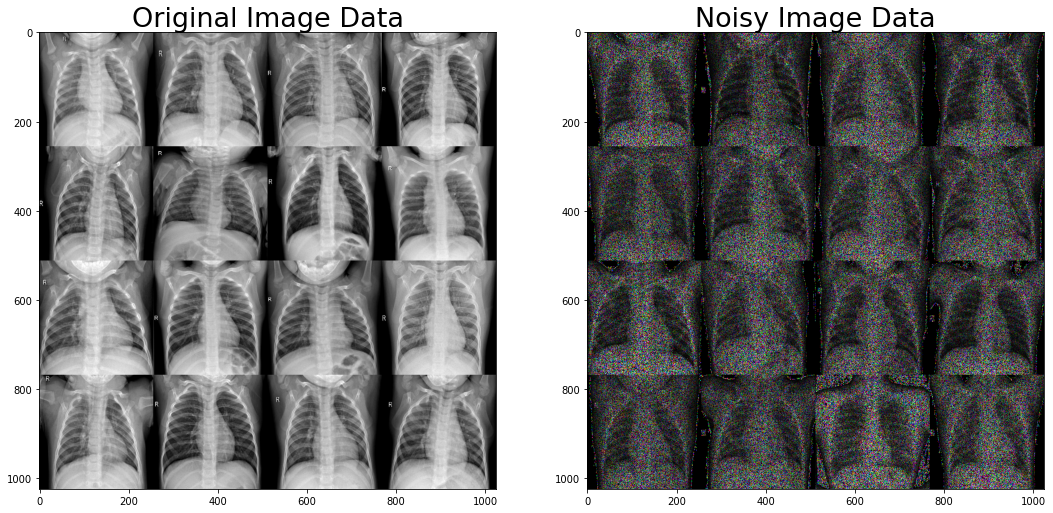

In [66]:
# visualization Parameters
f,ax = plt.subplots(1,2)
f.set_figheight(12)
f.set_figwidth(18)
img_in_row = 4

# For Original X-ray Data
ver_con = []
for i in range(img_in_row):  
    ind = np.random.randint(1,500)
    concated_image = cv2.hconcat(org_data[ind:ind+img_in_row])
    ver_con.append(concated_image)

ax[0].imshow(cv2.vconcat(ver_con))
ax[0].set_title('Original Image Data',size = 27)

# For Noisy X-ray Data
ver_con = []
for i in range(img_in_row):  
    ind = np.random.randint(1,500)
    concated_image = cv2.hconcat(noisy_data[ind:ind+img_in_row])
    ver_con.append(concated_image)

ax[1].imshow(cv2.vconcat(ver_con))   
ax[1].set_title('Noisy Image Data',size = 27)   

This includes the Image scaling between the range of 0 to 1 by Decibal scaling and splitting Data into Train and Test

In [4]:
# Noramlization
org_data = org_data/255

noisy_data = noisy_data/255

noisy_train_data,noisy_test_data, org_train_data,org_test_data = train_test_split(noisy_data,org_data,test_size = 0.3)

print('Training Data : ',noisy_train_data.shape)
print('Testing Data : ',noisy_test_data.shape)

Training Data :  (616, 256, 256, 3)
Testing Data :  (264, 256, 256, 3)


# Model Creation

Inside model creation er are going to implement the **Stacked Autoencoders** which will Lead to

*  **Feature Extraction**
*  **Image Denoising**
*  **Image Reconstruction** 



In [42]:
# Model Parameter specifications
img_shape = noisy_data[0].shape
batch_size = 32
epochs = 350

# Inpt Data
input = Input(shape = img_shape, name = 'Input Layer')

# ENCODER For first Phase (Auto-encoders)
x2 = Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same')(input)
x3 = MaxPooling2D(pool_size = (2,2), padding = 'same')(x2)
x4 = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(x3)
x5 = MaxPooling2D(pool_size = (2,2), padding = 'same')(x4)
x6 = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(x5)
x7 = MaxPooling2D(pool_size = (2,2), padding = 'same')(x6)
x8 = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x7)
ENCODER = MaxPooling2D(pool_size = (2,2), name = 'ENCODER')(x8)

# DECODER For Second Phase (Auto-encoders)
x9 = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(ENCODER)
x10 = UpSampling2D((2,2))(x9)
x11 = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(x10)
x12 = UpSampling2D((2,2))(x11)
x13 = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(x12)
x14 = UpSampling2D((2,2))(x13)
x15 = Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same')(x14)
x16 = UpSampling2D((2,2))(x15)

DECODER =  Conv2D(filters = 3, kernel_size = (1,1), activation = 'sigmoid', name = 'DECODER')(x16)

# functional API Model structure
generator = Model(input = input, outputs = DECODER) 

generator.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 32, 32, 128)       0   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


In [43]:
# Model compilation 
generator.compile(optimizer='adadelta', loss = 'binary_crossentropy')

In [44]:
# Model Training
output = generator.fit(noisy_train_data, org_train_data, epochs = epochs, batch_size = batch_size,
              validation_data = (noisy_test_data,org_test_data), verbose = 1)

Train on 616 samples, validate on 264 samples
Epoch 1/350
616/616 [==============================] - 9s 14ms/step - loss: 0.6881 - val_loss: 0.6760
Epoch 2/350
616/616 [==============================] - 7s 12ms/step - loss: 0.6398 - val_loss: 0.5897
Epoch 3/350
616/616 [==============================] - 7s 12ms/step - loss: 0.5974 - val_loss: 0.6823
Epoch 4/350
616/616 [==============================] - 7s 12ms/step - loss: 0.5983 - val_loss: 0.5799
Epoch 5/350
616/616 [==============================] - 7s 12ms/step - loss: 0.5864 - val_loss: 0.6538
Epoch 6/350
616/616 [==============================] - 7s 12ms/step - loss: 0.5889 - val_loss: 0.5757
Epoch 7/350
616/616 [==============================] - 7s 12ms/step - loss: 0.5783 - val_loss: 0.6273
Epoch 8/350
616/616 [==============================] - 7s 12ms/step - loss: 0.5832 - val_loss: 0.5717
Epoch 9/350
616/616 [==============================] - 7s 12ms/step - loss: 0.5749 - val_loss: 0.5694
Epoch 10/350
616/616 [==============

**Saving Model** for future Use in Deployment

In [ ]:
generator.save('/content/drive/My Drive/Denoising_autoencoder.h5')

# Model Evalution

In [124]:
val_loss = output.history.val_loss()
loss = output.history.loss()
reconstructed_data = generator.predict(noisy_test_data)

print('Reconstructed Data Shape : ',reconstructed_data.shape)
print('Training Reconstruction Loss : ',np.mean(loss))
print('Testing Reconstruction Loss : ',np.mean(val_loss))

Reconstructed Data Shape :  (264, 256, 256, 3)
Training Reconstruction Loss :  0.5568
Testing Reconstruction Loss :  0.5587


Text(0.5, 0, 'Original Image')

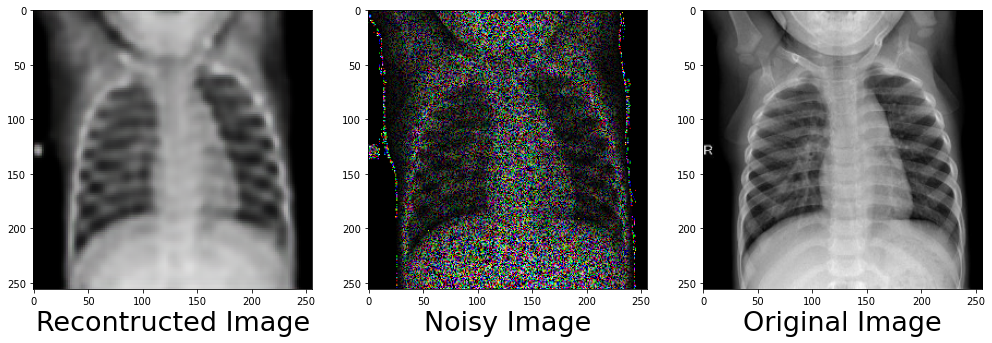

In [73]:
f,ax = plt.subplots(1,3) 
f.set_figheight(13)
f.set_figwidth(17)

ax[0].imshow(reconstructed_data[100])
ax[0].set_xlabel('Recontructed Image',size = 27)

ax[1].imshow(noisy_test_data[100])
ax[1].set_xlabel('Noisy Image',size = 27)

ax[2].imshow(org_test_data[100])
ax[2].set_xlabel('Original Image',size = 27)

# Reconstructed Data visualization

This will Demonstrate that how Significantly our Autoencoder Parameters learns Relevent Features and leads to very finite Reconstruction

Text(0.5, 1.0, 'Reconstructed Image Data\n')

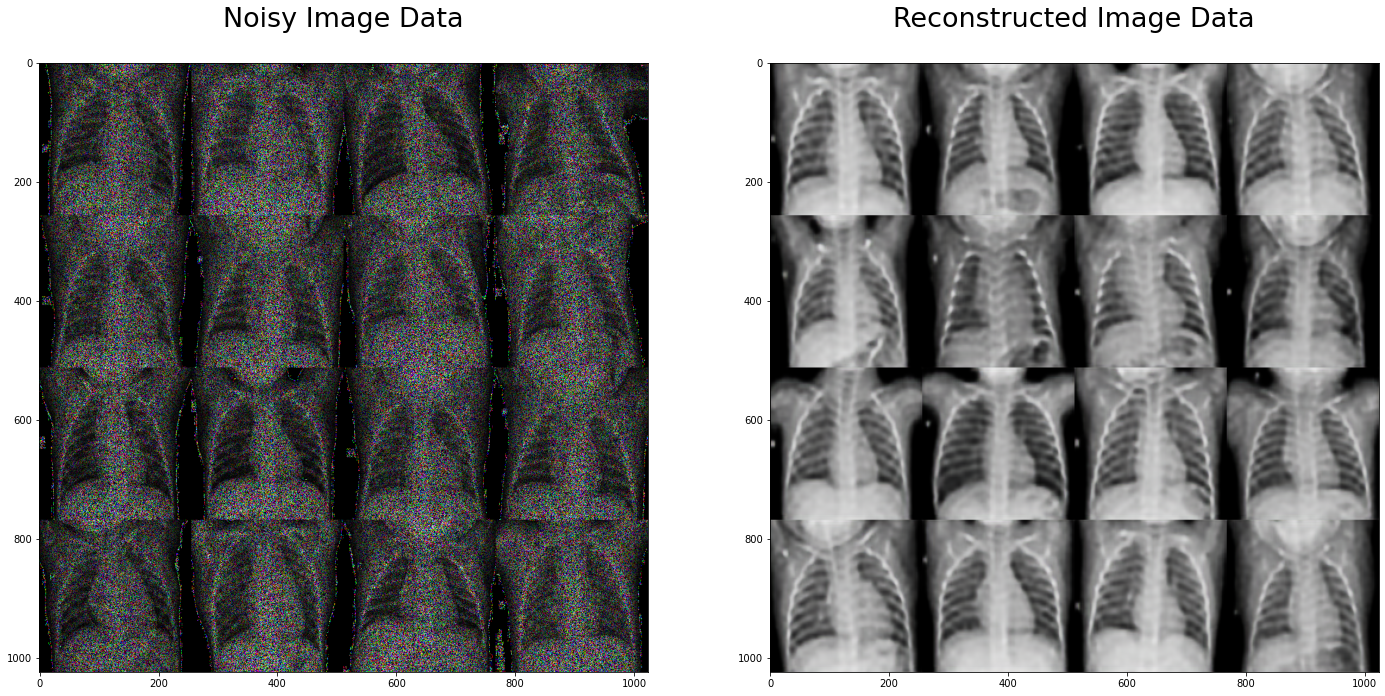

In [125]:
f,ax = plt.subplots(1,2)
f.set_figheight(18)
f.set_figwidth(24)
img_in_row = 4

'''
ver_con = []
for i in range(img_in_row):  
    ind = np.random.randint(1,200)
    concated_image = cv2.hconcat(org_data[ind:ind+img_in_row])
    ver_con.append(concated_image)

ax[0].imshow(cv2.vconcat(ver_con))
ax[0].set_title('Original Image Data',size = 27)
'''

ver_con = []
for i in range(img_in_row):  
    ind = np.random.randint(1,200)
    concated_image = cv2.hconcat(noisy_data[ind:ind+img_in_row])
    ver_con.append(concated_image)

ax[0].imshow(cv2.vconcat(ver_con))   
ax[0].set_title('Noisy Image Data\n',size = 27)   

ver_con = []
for i in range(img_in_row):  
    ind = np.random.randint(1,200)
    concated_image = cv2.hconcat(reconstructed_data[ind:ind+img_in_row])
    ver_con.append(concated_image)

ax[1].imshow(cv2.vconcat(ver_con))   
ax[1].set_title('Reconstructed Image Data\n',size = 27)   